In [55]:
import pandas as pd
import numpy as np

import neo4j
import netifaces
import os
import socket
import re

import pickle, os, datetime, time
import sqlite3

from netifaces import interfaces, ifaddresses, AF_INET
from neo4j import GraphDatabase
from neo4j import DEFAULT_DATABASE
from neo4j import WRITE_ACCESS
from neo4j import unit_of_work
from neo4j import Query

from datetime import datetime


In [56]:
env = "LS"

# At local
# Local machine에서 GPU를 사용할 수 있는 지 확인
import torch
#%tensorflow_version 2.x
import tensorflow as tf

print("Pytorch version = {}".format(torch.__version__))
print("Tensorflow version = {}".format(tf.__version__))

print("Pysical devices that Tensoflow detected = {}".format(tf.config.list_physical_devices()))
physical_devices = tf.config.list_physical_devices('GPU')

device_name = tf.test.gpu_device_name()
print('device_name: {}'.format(device_name))
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Pytorch version = 2.1.0+cu121
Tensorflow version = 2.15.0
Pysical devices that Tensoflow detected = [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
device_name: /device:GPU:0
Found GPU at: /device:GPU:0


2023-12-11 11:13:36.266214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 11:13:36.266283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 11:13:36.266307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 11:13:36.266526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 11:13:36.266537: I tensorflow/core/common_runtime/gpu/gpu

# Execution Variable

In [57]:
# 현재 코드가 실행되고 있는 경로 출력
print("\nCode path -----------------------------------------------------------")
print(os.getcwd())
print("-----------------------------------------------------------------------")

# 컨테이너 내부에서 ip address 확인
print("\nnetifaces -----------------------------------------------------------")
print(netifaces.interfaces())
print(netifaces.ifaddresses('lo'))

print(netifaces.ifaddresses('eth0'))
ADDRESS = ifaddresses("eth0")[2][0]["addr"]
print("eth0 address = ", ADDRESS)
print("-----------------------------------------------------------------------")



Code path -----------------------------------------------------------
/home/patrick/school/postech-F23/IMEN491V/graphDB
-----------------------------------------------------------------------

netifaces -----------------------------------------------------------
['lo', 'eth0']
{17: [{'addr': '00:00:00:00:00:00', 'peer': '00:00:00:00:00:00'}], 2: [{'addr': '127.0.0.1', 'netmask': '255.0.0.0', 'peer': '127.0.0.1'}], 10: [{'addr': '::1', 'netmask': 'ffff:ffff:ffff:ffff:ffff:ffff:ffff:ffff/128'}]}
{17: [{'addr': '00:15:5d:1d:5c:0a', 'broadcast': 'ff:ff:ff:ff:ff:ff'}], 2: [{'addr': '172.18.121.194', 'netmask': '255.255.240.0', 'broadcast': '172.18.127.255'}], 10: [{'addr': 'fe80::215:5dff:fe1d:5c0a%eth0', 'netmask': 'ffff:ffff:ffff:ffff::/64'}]}
eth0 address =  172.18.121.194
-----------------------------------------------------------------------


In [58]:
HOME = os.environ["HOME"]
print("\nHOME = {}".format(HOME))
#running_path = os.getcwd()
running_path = os.path.join(HOME, 'school/postech-F23/IMEN491V/graphDB')
print("\nrunning_path = {}".format(running_path))
save_path = os.path.join(running_path,"data")
print("\nsave_path = {}".format(save_path))
neo4j_path = "school/postech-F23/IMEN491V/graphDB/neo4j-community-5.14.0"
neo4j_import_path = os.path.join(neo4j_path, 'import')
neo4j_conf_path = os.path.join(neo4j_path, 'conf')
neo4j_bin_path = os.path.join(neo4j_path, 'bin')
neo4j_running_import_path = os.path.join(HOME, neo4j_import_path)
neo4j_running_conf_path = os.path.join(HOME, neo4j_conf_path)
neo4j_running_bin_path = os.path.join(HOME, neo4j_bin_path)
DATE = datetime.today().strftime("%Y_%m_%d")
print("\nDATE = {}".format(DATE))



HOME = /home/patrick

running_path = /home/patrick/school/postech-F23/IMEN491V/graphDB

save_path = /home/patrick/school/postech-F23/IMEN491V/graphDB/data

DATE = 2023_12_11


In [59]:
n4j_id = "neo4j"
n4j_pwd = "neo4j"  # Initial default password
n4j_bolt_port = 7687


In [60]:
import subprocess

if 0:
    # neo4j.conf 내용 확인
    print("\nCheck neo4j.conf-----------------------------------------------------")
    cmd = "cat"
    param = os.path.join(str(neo4j_running_conf_path),"neo4j.conf")
    result = subprocess.run([cmd,param], capture_output=True, universal_newlines=True)
    print(result.stdout)
    print("-----------------------------------------------------------------------")

if 0:
    # inference.py 내용 확인
    print("\nCheck inference.py---------------------------------------")
    cmd = "cat"
    param = os.path.join(str(running_path),"inference.py")
    result = subprocess.run([cmd,param], capture_output=True, universal_newlines=True)
    print(result.stdout)
    print("-----------------------------------------------------------------------")

# neo4j stop - 이전 수행 결과로 7687 port가 occupied되어 있을 가능성 제거 위해
print("\nStop neo4j-----------------------------------------------------------")
cmd = os.path.join(str(neo4j_running_bin_path),"neo4j")
param = "stop"
result = subprocess.run([cmd,param], capture_output=True, universal_newlines=True)
print(result.stdout)
print("-----------------------------------------------------------------------")

# neo4j start
print("\nStart neo4j----------------------------------------------------------")
cmd = os.path.join(str(neo4j_running_bin_path),"neo4j")
param1 = "start"
param2 = "--verbose"
result = subprocess.run([cmd,param1,param2], capture_output=True, universal_newlines=True)
print(result.stdout)
cmd = "sleep"
param = "3"
result = subprocess.run([cmd,param], capture_output=True, universal_newlines=True)
print(result.stdout)
print("-----------------------------------------------------------------------")

# Password change
#os.system('/home/splunk/scripts/neo4j-community-4.4.5/bin/neo4j-admin set-initial-password neo4jmc')
if(n4j_pwd=="neo4j"):
    print("\nPassword change to wjdtjq001-------------------------------------------")
    cmd = os.path.join(str(neo4j_running_bin_path),"neo4j-admin")
    param1 = "set-initial-password"
    param2 = "wjdtjq001"
    result = subprocess.run([cmd,param1,param2], capture_output=True, universal_newlines=True)
    print(result.stdout)
    n4j_pwd = "wjdtjq001"
    print("-----------------------------------------------------------------------")

# save_path의 node_*.csv를 neo4j_running_import_path로 복사
print("\nCopy node_*.csv from {} to {}".format(save_path, neo4j_running_import_path))
os.system(f"cp {save_path}/node_*.csv {neo4j_running_import_path}/")
#os.system(f"cp {save_path}/cypher_query_list.pkl {neo4j_running_import_path}/")
print("-----------------------------------------------------------------------")

if 0:
    # Neo4j file들의 owner 확인
    print("\nCheck file owners----------------------------------------------------")
    print(os.system("ls -al /home/splunk/scripts/neo4j-community-4.4.5/*/*"))
    cmd = "ls"
    param1 = "-al"
    param2 = os.path.join(str(neo4j_running_bin_path), "..")
    result = subprocess.run([cmd,param1,param2], capture_output=True, universal_newlines=True)
    print(result.stdout)
    print("-----------------------------------------------------------------------")

# Container의 network 상태 확인
print("\nChecking container network status -----------------------------------")
if 1:
    # netstat -lnp
    print("netstat -lnp")
    cmd = "netstat"
    param = "-lnp"
    result = subprocess.run([cmd,param], capture_output=True, universal_newlines=True)
    print(result.stdout)
if 0:
    # ping
    print("ping -c 3 ...")
    cmd = "ping"
    param1 = "-c"
    param2 = "3"
    param3 = "localhost"
    result = subprocess.run([cmd,param1,param2,param3], capture_output=True, universal_newlines=True)
    print(result.stdout)
    cmd = "ping"
    param1 = "-c"
    param2 = "3"
    param3 = "127.0.0.1"
    result = subprocess.run([cmd,param1,param2,param3], capture_output=True, universal_newlines=True)
    print(result.stdout)
if 0:
    # ifconfig
    print("ifconfig")
    cmd = "ifconfig"
    result = subprocess.run([cmd,], capture_output=True, universal_newlines=True)
    print(result.stdout)
if 0:
    # curl
    print("curl")
    print(os.system("curl http://localhost:7474"))
    print(os.system("curl bolt://localhost:7689"))
    print(os.system("curl http://127.0.0.1:7474"))
    print(os.system("curl bolt://127.0.0.1:7689"))
if 0:
    # lsof
    print("lsof")
    cmd = "lsof"
    param1 = "-i"
    param2 = "-P"
    param3 = "-n"
    result = subprocess.run([cmd,param1,param2,param3], capture_output=True, universal_newlines=True)
    print(result.stdout)
print("-----------------------------------------------------------------------")



Stop neo4j-----------------------------------------------------------
Neo4j is not running.

-----------------------------------------------------------------------

Start neo4j----------------------------------------------------------
neo4j 5.14.0
VM Name: OpenJDK 64-Bit Server VM
VM Vendor: Private Build
VM Version: 21.0.1+12-Ubuntu-222.04
JIT compiler: HotSpot 64-Bit Tiered Compilers
VM Arguments: [-Xmx128m, -Dapp.name=neo4j, -Dapp.pid=999090, -Dapp.repo=/home/patrick/school/postech-F23/IMEN491V/graphDB/neo4j-community-5.14.0/repo, -Dapp.home=/home/patrick/school/postech-F23/IMEN491V/graphDB/neo4j-community-5.14.0, -Dbasedir=/home/patrick/school/postech-F23/IMEN491V/graphDB/neo4j-community-5.14.0]
Configuration files used (ordered by priority):
/home/patrick/school/postech-F23/IMEN491V/graphDB/neo4j-community-5.14.0/conf/neo4j.conf
--------------------
Directories in use:
home:         /home/patrick/school/postech-F23/IMEN491V/graphDB/neo4j-community-5.14.0
config:       /home/patr

cp: cannot stat '/home/patrick/school/postech-F23/IMEN491V/graphDB/data/node_*.csv': No such file or directory


# 4. Connection test

In [61]:
class Neo4jConnection:

    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            #self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd), max_transaction_retry_time=300)
            #self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd), max_transaction_retry_time=300, encrypted=False)
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self.__driver is not None:
            self.__driver.close()

    def verify_connectivity(self):
        if self.__driver is not None:
            print(self.__driver.verify_connectivity())

    def supports_multi_db(self):
        if self.__driver is not None:
            print(self.__driver.supports_multi_db())
    def default_host(self):
        if self.__driver is not None:
            return self.__driver.default_host
    def default_port(self):
        if self.__driver is not None:
            return self.__driver.default_port
    def encrypted(self):
        if self.__driver is not None:
            return self.__driver.encrypted

    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized"
        session = None
        response = None
        try:
            #session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response


In [62]:
ADDRESS = "localhost"
PORT = n4j_bolt_port # 정적 PORT
pwd = n4j_pwd
print(ADDRESS, PORT, n4j_id, pwd)

print("Test begins")
conn = Neo4jConnection(uri=f"bolt://{ADDRESS}:{PORT}", user= n4j_id , pwd= pwd)
#conn = Neo4jConnection(uri="bolt://localhost:7689", user="neo4j", pwd="neo4jmc")
print("Connected with ", conn)

print("Connection can be verified if Neo4j/4.4.4 is returned")
conn.verify_connectivity()

print("Connection for multiple DBs?")
conn.supports_multi_db()

conn.close()
print("Test completed")


localhost 7687 neo4j wjdtjq001
Test begins
Connected with  <__main__.Neo4jConnection object at 0x7f7acbd8c5e0>
Connection can be verified if Neo4j/4.4.4 is returned
None
Connection for multiple DBs?
True
Test completed


# 5. Graph

In [ ]:
# Create CX nodes
# CX nodes have a set of custom properites. So, we create it manually.

cypher_query = \
    '''
    LOAD CSV WITH HEADERS FROM "file:///AI_sample.csv" AS row
    CREATE (label_ROW:ROW)
    SET label_ROW = row
    SET label_ROW.YEAR_YYYY = row.YEAR_YYYY
    SET label_ROW.MONTH_YYYYMM = row.MONTH_YYYYMM
    SET label_ROW.WEEK_YYYYWWW = row.WEEK_YYYYWWW
    SET label_ROW.RECLAIM_PERIOD = row.RECLAIM_PERIOD
    SET label_ROW.SUBSIDIARY_NAME = row.SUBSIDIARY_NAME
    SET label_ROW.CAPTIVE_CHANNEL_FLAG = row.CAPTIVE_CHANNEL_FLAG
    SET label_ROW.COMPANY_CODE = row.COMPANY_CODE
    SET label_ROW.DIVISION_NAME = row.DIVISION_NAME
    SET label_ROW.MODEL_CODE = row.MODEL_CODE
    SET label_ROW.PARTS_NO1 = row.PARTS_NO1
    SET label_ROW.PARTS_NO2 = row.PARTS_NO2
    SET label_ROW.PARTS_NO3 = row.PARTS_NO3
    SET label_ROW.PARTS_NO4 = row.PARTS_NO4
    SET label_ROW.PARTS_NO5 = row.PARTS_NO5
    SET label_ROW.PREV_PARTS_NO1 = row.PREV_PARTS_NO1
    SET label_ROW.PREV_PARTS_NO2 = row.PREV_PARTS_NO2
    SET label_ROW.PREV_PARTS_NO3 = row.PREV_PARTS_NO3
    SET label_ROW.PREV_PARTS_NO4 = row.PREV_PARTS_NO4
    SET label_ROW.PREV_PARTS_NO5 = row.PREV_PARTS_NO5
    SET label_ROW.RECEIPT_SYMPTOM = row.RECEIPT_SYMPTOM
    SET label_ROW.RECEIPT_NUMBER = row.RECEIPT_NUMBER
    SET label_ROW.PREV_RECEIPT_NUMBER = row.PREV_RECEIPT_NUMBER
    SET label_ROW.REPAIR_START_DATE = row.REPAIR_START_DATE
    SET label_ROW.REPAIR_END_DATE = row.REPAIR_END_DATE
    SET label_ROW.CENTER_CODE = row.CENTER_CODE
    SET label_ROW.PREV_CENTER_CODE = row.PREV_CENTER_CODE
    SET label_ROW.PRODUCT_NAME = row.PRODUCT_NAME
    SET label_ROW.PRODUCT_NAME_DETAIL = row.PRODUCT_NAME_DETAIL
    SET label_ROW.RECLAIM = row.RECLAIM
    SET label_ROW.WARRANTY_TYPE = row.WARRANTY_TYPE
    SET label_ROW.PREV_WARRANTY_TYPE = row.PREV_WARRANTY_TYPE
    SET label_ROW.SVC_TYPE = row.SVC_TYPE
    SET label_ROW.PREV_SVC_TYPE = row.PREV_SVC_TYPE
    SET label_ROW.ENGINEER_CODE = row.ENGINEER_CODE
    SET label_ROW.PREV_ENGINEER_CODE = row.PREV_ENGINEER_CODE
    SET label_ROW.ENGINEER_SYMPTOM = row.ENGINEER_SYMPTOM
    SET label_ROW.ENGINEER_REPAIR = row.ENGINEER_REPAIR
    SET label_ROW.PREV_ENGINEER_SYMPTOM = row.PREV_ENGINEER_SYMPTOM
    SET label_ROW.PREV_ENGINEER_REPAIR = row.PREV_ENGINEER_REPAIR
    SET label_ROW.KEY_PARTS1 = row.KEY_PARTS1
    SET label_ROW.KEY_PARTS2 = row.KEY_PARTS2
    SET label_ROW.KEY_PARTS3 = row.KEY_PARTS3
    SET label_ROW.KEY_PARTS4 = row.KEY_PARTS4
    SET label_ROW.KEY_PARTS5 = row.KEY_PARTS5
    SET label_ROW.PREV_KEY_PARTS1 = row.PREV_KEY_PARTS1
    SET label_ROW.PREV_KEY_PARTS2 = row.PREV_KEY_PARTS2
    SET label_ROW.PREV_KEY_PARTS3 = row.PREV_KEY_PARTS3
    SET label_ROW.PREV_KEY_PARTS4 = row.PREV_KEY_PARTS4
    SET label_ROW.PREV_KEY_PARTS5 = row.PREV_KEY_PARTS5
    SET label_ROW.KEY_PARTS_REMARK1 = row.KEY_PARTS_REMARK1
    SET label_ROW.KEY_PARTS_REMARK2 = row.KEY_PARTS_REMARK2
    SET label_ROW.KEY_PARTS_REMARK3 = row.KEY_PARTS_REMARK3
    SET label_ROW.KEY_PARTS_REMARK4 = row.KEY_PARTS_REMARK4
    SET label_ROW.KEY_PARTS_REMARK5 = row.KEY_PARTS_REMARK5
    SET label_ROW.PREV_KEY_PARTS_REMARK1 = row.PREV_KEY_PARTS_REMARK1
    SET label_ROW.PREV_KEY_PARTS_REMARK2 = row.PREV_KEY_PARTS_REMARK2
    SET label_ROW.PREV_KEY_PARTS_REMARK3 = row.PREV_KEY_PARTS_REMARK3
    SET label_ROW.PREV_KEY_PARTS_REMARK4 = row.PREV_KEY_PARTS_REMARK4
    SET label_ROW.PREV_KEY_PARTS_REMARK5 = row.PREV_KEY_PARTS_REMARK5
    SET label_ROW.MULTICLAIM = row.MULTICLAIM
    SET label_ROW.PREV_RECEIPT_SYMPTOM = row.PREV_RECEIPT_SYMPTOM

    RETURN label_ROW
    '''

conn.query(cypher_query, db = DEFAULT_DATABASE)


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


[<Record label_ROW=<Node element_id='4:4b34c496-3e61-4fa9-9bca-8091b052ec54:0' labels=frozenset({'ROW'}) properties={'WEEK_YYYYWWW': '10', 'ENGINEER_CODE': '9618', 'PARTS_DESC1': 'Drier Assembly', 'PARTS_DESC2': 'Compressor,Set Assembly', 'SUBSIDIARY_NAME': '0', 'MONTH_YYYYMM': '2', 'PREV_WARRANTY_TYPE': '6', 'RECLAIM': '1', 'KEY_PARTS4': '0', 'KEY_PARTS_REMARK1': '4', 'PREV_KEY_PARTS1': '0', 'COMPANY_CODE': '1', 'KEY_PARTS5': '0', 'KEY_PARTS_REMARK2': '4', 'PREV_KEY_PARTS3': '0', 'PREV_KEY_PARTS2': '0', 'KEY_PARTS_REMARK5': '4', 'KEY_PARTS1': '0', 'TO_RECLAIM': '0', 'KEY_PARTS_REMARK3': '4', 'KEY_PARTS2': '0', 'KEY_PARTS_REMARK4': '4', 'KEY_PARTS3': '0', 'PREV_PARTS_NO1': '21077', 'PREV_PARTS_NO2': '21077', 'PREV_PARTS_NO3': '21077', 'PREV_PARTS_NO4': '21077', 'PREV_PARTS_NO5': '21077', 'PRODUCT_NAME': '6', 'PREV_RECEIPT_SYMPTOM': '165', 'CENTER_CODE': '786', 'WARRANTY_TYPE': '4', 'RECEIPT_SYMPTOM': '258', 'PREV_ENGINEER_CODE': '18449', 'MULTICLAIM': '2', 'YEAR_YYYY': '0', 'RECEIPT_NU

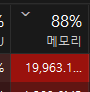
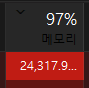

In [ ]:
node_cols = ['YEAR_YYYY', 'MONTH_YYYYMM', 'WEEK_YYYYWWW', 'RECLAIM_PERIOD', 'SUBSIDIARY_NAME', 'CAPTIVE_CHANNEL_FLAG', 'COMPANY_CODE', 'DIVISION_NAME', 'MODEL_CODE', 'PRODUCT_NAME', 'PRODUCT_NAME_DETAIL', 'RECLAIM', 'MULTICLAIM', 'PARTS', 'CENTER', 'WARRANTY', 'SVC', 'ENG_CODE', 'ENG_REPAIR', 'ENG_SYM', 'KEY_PARTS', 'KEY_PARTS_REMARK', 'RECEIPT_SYM']

uni_cols = ['YEAR_YYYY', 'MONTH_YYYYMM', 'WEEK_YYYYWWW', 'RECLAIM_PERIOD', 'SUBSIDIARY_NAME', 'CAPTIVE_CHANNEL_FLAG', 'COMPANY_CODE', 'DIVISION_NAME', 'MODEL_CODE', 'PRODUCT_NAME', 'PRODUCT_NAME_DETAIL', 'RECLAIM', 'MULTICLAIM']

parts = ['PARTS_NO1', 'PARTS_NO2', 'PARTS_NO3', 'PARTS_NO4', 'PARTS_NO5', 'PREV_PARTS_NO1', 'PREV_PARTS_NO2', 'PREV_PARTS_NO3', 'PREV_PARTS_NO4', 'PREV_PARTS_NO5']

center = ['CENTER_CODE', 'PREV_CENTER_CODE']

warranty = ['WARRANTY_TYPE', 'PREV_WARRANTY_TYPE']

svc = ['SVC_TYPE', 'PREV_SVC_TYPE']

eng_code = ['ENGINEER_CODE', 'PREV_ENGINEER_CODE']

eng_repair = ['ENGINEER_REPAIR', 'PREV_ENGINEER_REPAIR']

eng_sym = ['ENGINEER_SYMPTOM', 'PREV_ENGINEER_SYMPTOM']

key_parts = ['KEY_PARTS1', 'KEY_PARTS2', 'KEY_PARTS3', 'KEY_PARTS4', 'KEY_PARTS5', 'PREV_KEY_PARTS1', 'PREV_KEY_PARTS2', 'PREV_KEY_PARTS3', 'PREV_KEY_PARTS4', 'PREV_KEY_PARTS5']

key_parts_remark = ['KEY_PARTS_REMARK1', 'KEY_PARTS_REMARK2', 'KEY_PARTS_REMARK3', 'KEY_PARTS_REMARK4', 'KEY_PARTS_REMARK5', 'PREV_KEY_PARTS_REMARK1', 'PREV_KEY_PARTS_REMARK2', 'PREV_KEY_PARTS_REMARK3', 'PREV_KEY_PARTS_REMARK4', 'PREV_KEY_PARTS_REMARK5']

receipt_sym = ['RECEIPT_SYMPTOM', 'PREV_RECEIPT_SYMPTOM']


In [ ]:
for col in node_cols:
    cypher_query = \
    f'LOAD CSV WITH HEADERS FROM "file:///data/{col}.csv" AS row\n' + \
    f'CREATE (label_{col}:{col})\n' + \
    f'SET label_{col} = row\n' + \
    f'SET label_{col}.{col} = row.index\n' + \
    f'RETURN label_{col}\n'
    conn.query(cypher_query, db = DEFAULT_DATABASE)


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


# Edge connection


In [ ]:
def connect_edge(conn, node_type1, node_type2, key1, key2, relation_type):
    cypher_query = \
        "MATCH (n : " f"{node_type1}" "), (m: " f"{node_type2}" ") " \
        "WHERE n." f"{key1}" " = m." f"{key2} " \
        "CREATE (n)-[:" f"{relation_type}" "]->(m) " \
        "RETURN n.RECEIPT_NUMBER, m." f"{key2}" " LIMIT 10"
    print(cypher_query)
    print(conn.query(cypher_query, db = DEFAULT_DATABASE))


In [ ]:
# connect previous row to current row
connect_edge(conn, 'ROW', 'ROW', 'RECEIPT_NUMBER', 'PREV_RECEIPT_NUMBER', 'REL_ROW_RECEIPT_PREV')


MATCH (n : ROW), (m: ROW) WHERE n.RECEIPT_NUMBER = m.PREV_RECEIPT_NUMBER CREATE (n)-[:REL_ROW_RECEIPT_PREV]->(m) RETURN n.RECEIPT_NUMBER, m.PREV_RECEIPT_NUMBER LIMIT 10


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


[<Record n.RECEIPT_NUMBER='LGE_REC_56145' m.PREV_RECEIPT_NUMBER='LGE_REC_56145'>, <Record n.RECEIPT_NUMBER='LGE_REC_9952737' m.PREV_RECEIPT_NUMBER='LGE_REC_9952737'>, <Record n.RECEIPT_NUMBER='LGE_REC_2876921' m.PREV_RECEIPT_NUMBER='LGE_REC_2876921'>, <Record n.RECEIPT_NUMBER='LGE_REC_6919621' m.PREV_RECEIPT_NUMBER='LGE_REC_6919621'>, <Record n.RECEIPT_NUMBER='LGE_REC_7845745' m.PREV_RECEIPT_NUMBER='LGE_REC_7845745'>, <Record n.RECEIPT_NUMBER='LGE_REC_7849032' m.PREV_RECEIPT_NUMBER='LGE_REC_7849032'>, <Record n.RECEIPT_NUMBER='LGE_REC_1935354' m.PREV_RECEIPT_NUMBER='LGE_REC_1935354'>, <Record n.RECEIPT_NUMBER='LGE_REC_2889325' m.PREV_RECEIPT_NUMBER='LGE_REC_2889325'>, <Record n.RECEIPT_NUMBER='LGE_REC_586389' m.PREV_RECEIPT_NUMBER='LGE_REC_586389'>, <Record n.RECEIPT_NUMBER='LGE_REC_9362840' m.PREV_RECEIPT_NUMBER='LGE_REC_9362840'>]


In [ ]:
for col in uni_cols:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', col, col, col, 'REL_ROW_' + col)


--------------------
YEAR_YYYY
MATCH (n : ROW), (m: YEAR_YYYY) WHERE n.YEAR_YYYY = m.YEAR_YYYY CREATE (n)-[:REL_ROW_YEAR_YYYY]->(m) RETURN n.RECEIPT_NUMBER, m.YEAR_YYYY LIMIT 10


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


[<Record n.RECEIPT_NUMBER='LGE_REC_1210909' m.YEAR_YYYY='0'>, <Record n.RECEIPT_NUMBER='LGE_REC_1180964' m.YEAR_YYYY='0'>, <Record n.RECEIPT_NUMBER='LGE_REC_8738787' m.YEAR_YYYY='0'>, <Record n.RECEIPT_NUMBER='LGE_REC_13288756' m.YEAR_YYYY='1'>, <Record n.RECEIPT_NUMBER='LGE_REC_1983564' m.YEAR_YYYY='0'>, <Record n.RECEIPT_NUMBER='LGE_REC_5372937' m.YEAR_YYYY='0'>, <Record n.RECEIPT_NUMBER='LGE_REC_12387657' m.YEAR_YYYY='1'>, <Record n.RECEIPT_NUMBER='LGE_REC_13286316' m.YEAR_YYYY='1'>, <Record n.RECEIPT_NUMBER='LGE_REC_43764' m.YEAR_YYYY='0'>, <Record n.RECEIPT_NUMBER='LGE_REC_6916952' m.YEAR_YYYY='0'>]
--------------------
MONTH_YYYYMM
MATCH (n : ROW), (m: MONTH_YYYYMM) WHERE n.MONTH_YYYYMM = m.MONTH_YYYYMM CREATE (n)-[:REL_ROW_MONTH_YYYYMM]->(m) RETURN n.RECEIPT_NUMBER, m.MONTH_YYYYMM LIMIT 10
[<Record n.RECEIPT_NUMBER='LGE_REC_1210909' m.MONTH_YYYYMM='2'>, <Record n.RECEIPT_NUMBER='LGE_REC_1180964' m.MONTH_YYYYMM='2'>, <Record n.RECEIPT_NUMBER='LGE_REC_8738787' m.MONTH_YYYYMM='11'>

In [ ]:
# Parts
for col in parts:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'PARTS', col, 'PARTS', 'REL_ROW_' + col)

# center
for col in center:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'CENTER', col, 'CENTER', 'REL_ROW_' + col)

# warranty
for col in warranty:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'WARRANTY', col, 'WARRANTY', 'REL_ROW_' + col)

# svc
for col in svc:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'SVC', col, 'SVC', 'REL_ROW_' + col)

In [ ]:
# i would like to see a relation is created between two nodes in neo4j
# create me a querty to do this
query = "MATCH (n:ROW)-[r:REL_ROW_KEY_PARTS1]->(m:KEY_PARTS) RETURN n.RECEIPT_NUMBER, m LIMIT 10"
conn.query(query, db = DEFAULT_DATABASE)


In [ ]:
# eng_code
for col in eng_code:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'ENG_CODE', col, 'ENG_CODE', 'REL_ROW_' + col)

# eng_repair
for col in eng_repair:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'ENG_REPAIR', col, 'ENG_REPAIR', 'REL_ROW_' + col)

# eng_sym
for col in eng_sym:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'ENG_SYM', col, 'ENG_SYM', 'REL_ROW_' + col)

In [ ]:
# key_parts
for col in key_parts:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'KEY_PARTS', col, 'KEY_PARTS', 'REL_ROW_' + col)

# key_parts_remark
for col in key_parts_remark:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'KEY_PARTS_REMARK', col, 'KEY_PARTS_REMARK', 'REL_ROW_' + col)

# receipt_sym
for col in receipt_sym:
    print("--------------------")
    print(col)
    connect_edge(conn, 'ROW', 'RECEIPT_SYM', col, 'RECEIPT_SYM', 'REL_ROW_' + col)


--------------------
PARTS_NO1
MATCH (n : ROW), (m: PARTS) WHERE n.PARTS_NO1 = m.PARTS CREATE (n)-[:REL_ROW_PARTS_NO1]->(m) RETURN n.RECEIPT_NUMBER, m.PARTS LIMIT 10


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


[<Record n.RECEIPT_NUMBER='LGE_REC_1210909' m.PARTS='414'>, <Record n.RECEIPT_NUMBER='LGE_REC_1180964' m.PARTS='6962'>, <Record n.RECEIPT_NUMBER='LGE_REC_8738787' m.PARTS='5147'>, <Record n.RECEIPT_NUMBER='LGE_REC_13288756' m.PARTS='414'>, <Record n.RECEIPT_NUMBER='LGE_REC_1983564' m.PARTS='14180'>, <Record n.RECEIPT_NUMBER='LGE_REC_5372937' m.PARTS='21077'>, <Record n.RECEIPT_NUMBER='LGE_REC_12387657' m.PARTS='21077'>, <Record n.RECEIPT_NUMBER='LGE_REC_13286316' m.PARTS='21634'>, <Record n.RECEIPT_NUMBER='LGE_REC_43764' m.PARTS='14255'>, <Record n.RECEIPT_NUMBER='LGE_REC_6916952' m.PARTS='6962'>]
--------------------
PARTS_NO2
MATCH (n : ROW), (m: PARTS) WHERE n.PARTS_NO2 = m.PARTS CREATE (n)-[:REL_ROW_PARTS_NO2]->(m) RETURN n.RECEIPT_NUMBER, m.PARTS LIMIT 10
[<Record n.RECEIPT_NUMBER='LGE_REC_1210909' m.PARTS='14255'>, <Record n.RECEIPT_NUMBER='LGE_REC_1180964' m.PARTS='14255'>, <Record n.RECEIPT_NUMBER='LGE_REC_8738787' m.PARTS='12239'>, <Record n.RECEIPT_NUMBER='LGE_REC_13288756' m

# 6. Graph projection

In [65]:
needed_relation = ['YEAR_YYYY', 'MONTH_YYYYMM', 'WEEK_YYYYWWW', 'RECLAIM_PERIOD',
       'SUBSIDIARY_NAME', 'CAPTIVE_CHANNEL_FLAG', 'COMPANY_CODE',
       'DIVISION_NAME', 'MODEL_CODE', 'PARTS_NO1', 'PARTS_NO2', 'PARTS_NO3',
       'PARTS_NO4', 'PARTS_NO5', 'PREV_PARTS_NO1', 'PREV_PARTS_NO2',
       'PREV_PARTS_NO3', 'PREV_PARTS_NO4', 'PREV_PARTS_NO5',  'RECEIPT_SYMPTOM',
       'RECEIPT_NUMBER', 'PREV_RECEIPT_NUMBER', 'REPAIR_START_DATE',
       'REPAIR_END_DATE', 'CENTER_CODE', 'PREV_CENTER_CODE', 'PRODUCT_NAME',
       'PRODUCT_NAME_DETAIL', 'RECLAIM', 'WARRANTY_TYPE', 'PREV_WARRANTY_TYPE',
       'SVC_TYPE', 'PREV_SVC_TYPE', 'ENGINEER_CODE', 'PREV_ENGINEER_CODE',
       'ENGINEER_SYMPTOM', 'ENGINEER_REPAIR', 'PREV_ENGINEER_SYMPTOM',
       'PREV_ENGINEER_REPAIR', 'KEY_PARTS1', 'KEY_PARTS2', 'KEY_PARTS3',
       'KEY_PARTS4', 'KEY_PARTS5', 'PREV_KEY_PARTS1', 'PREV_KEY_PARTS2',
       'PREV_KEY_PARTS3', 'PREV_KEY_PARTS4', 'PREV_KEY_PARTS5',
       'KEY_PARTS_REMARK1', 'KEY_PARTS_REMARK2', 'KEY_PARTS_REMARK3',
       'KEY_PARTS_REMARK4', 'KEY_PARTS_REMARK5', 'PREV_KEY_PARTS_REMARK1',
       'PREV_KEY_PARTS_REMARK2', 'PREV_KEY_PARTS_REMARK3',
       'PREV_KEY_PARTS_REMARK4', 'PREV_KEY_PARTS_REMARK5', 'MULTICLAIM',
       'PREV_RECEIPT_SYMPTOM']

cypher_query = \
    '''
    // Syntax
    //    CALL gds.graph.project(
    //      graphName: String,
    //      nodeProjection: String or List or Map,
    //      relationshipProjection: String or List or Map,
    //      configuration: Map
    //    ) YIELD
    //      graphName: String,
    //      nodeProjection: Map,
    //      nodeCount: Integer,
    //      relationshipProjection: Map,
    //      relationshipCount: Integer,
    //      projectMillis: Integer
    //
    call gds.graph.project(
        /* Graph Name */
        "SMILE",
        /* Node projection */
        // <projected-label> : {
        //      label: <neo4j-label>,
        //      properties: <neo4j-property-key>
        //  }
        //{
        //    ROW : {label : "ROW", properties : ['YEAR_YYYY', 'MONTH_YYYYMM', 'WEEK_YYYYWWW', 'RECLAIM_PERIOD', 'SUBSIDIARY_NAME', 'CAPTIVE_CHANNEL_FLAG', 'COMPANY_CODE', 'DIVISION_NAME', 'MODEL_CODE', 'PRODUCT_NAME', 'PRODUCT_NAME_DETAIL', 'RECLAIM', 'MULTICLAIM', 'PARTS', 'CENTER', 'WARRANTY', 'SVC', 'ENG_CODE', 'ENG_REPAIR', 'ENG_SYM', 'KEY_PARTS', 'KEY_PARTS_REMARK', 'RECEIPT_SYM']},
        //    YEAR_YYYY : {label : "YEAR_YYYY", properties : ['YEAR_YYYY']},
        //    MONTH_YYYYMM : {label : "MONTH_YYYYMM", properties : ['MONTH_YYYYMM']},
        //    WEEK_YYYYWWW : {label : "WEEK_YYYYWWW", properties : ['WEEK_YYYYWWW']},
        //    RECLAIM_PERIOD : {label : "RECLAIM_PERIOD", properties : ['RECLAIM_PERIOD']},
        //    SUBSIDIARY_NAME : {label : "SUBSIDIARY_NAME", properties : ['SUBSIDIARY_NAME']},
        //    CAPTIVE_CHANNEL_FLAG : {label : "CAPTIVE_CHANNEL_FLAG", properties : ['CAPTIVE_CHANNEL_FLAG']},
        //    COMPANY_CODE : {label : "COMPANY_CODE", properties : ['COMPANY_CODE']},
        //    DIVISION_NAME : {label : "DIVISION_NAME", properties : ['DIVISION_NAME']},
        //    MODEL_CODE : {label : "MODEL_CODE", properties : ['MODEL_CODE']},
        //    PRODUCT_NAME : {label : "PRODUCT_NAME", properties : ['PRODUCT_NAME']},
        //    PRODUCT_NAME_DETAIL : {label : "PRODUCT_NAME_DETAIL", properties : ['PRODUCT_NAME_DETAIL']},
        //    RECLAIM : {label : "RECLAIM", properties : ['RECLAIM']},
        //    MULTICLAIM : {label : "MULTICLAIM", properties : ['MULTICLAIM']},
        //    PARTS : {label : "PARTS", properties : ['PARTS']},
        //    CENTER : {label : "CENTER", properties : ['CENTER']},
        //    WARRANTY : {label : "WARRANTY", properties : ['WARRANTY']},
        //    SVC : {label : "SVC", properties : ['SVC']},
        //    ENG_CODE : {label : "ENG_CODE", properties : ['ENG_CODE']},
        //    ENG_REPAIR : {label : "ENG_REPAIR", properties : ['ENG_REPAIR']},
        //    ENG_SYM : {label : "ENG_SYM", properties : ['ENG_SYM']},
        //    KEY_PARTS : {label : "KEY_PARTS", properties : ['KEY_PARTS']},
        //    KEY_PARTS_REMARK : {label : "KEY_PARTS_REMARK", properties : ['KEY_PARTS_REMARK']},
        //    RECEIPT_SYM : {label : "RECEIPT_SYM", properties : ['RECEIPT_SYM']}
        //},
        ['ROW', 'YEAR_YYYY', 'MONTH_YYYYMM', 'WEEK_YYYYWWW', 'RECLAIM_PERIOD', 'SUBSIDIARY_NAME', 'CAPTIVE_CHANNEL_FLAG', 'COMPANY_CODE', 'DIVISION_NAME', 'MODEL_CODE', 'PRODUCT_NAME', 'PRODUCT_NAME_DETAIL', 'RECLAIM', 'MULTICLAIM', 'PARTS', 'CENTER', 'WARRANTY', 'SVC', 'ENG_CODE', 'ENG_REPAIR', 'ENG_SYM', 'KEY_PARTS', 'KEY_PARTS_REMARK', 'RECEIPT_SYM'],
        /* Relationship projection */
        // <projected-type>: {
        //      type: <neo4j-type>,
        //      orientation: <orientation>,
        //      aggregation: <aggregation-type>,
        //      properties: <neo4j-property-key>
        //  }
        // The orientation can have one of NATURAL, UNDIRECTED, REVERSE
        // The aggregation can have one of NONE, MIN, MAX, SUM, SINGLE, COUNT
        {
            REL_ROW_YEAR_YYYY : {orientation : "UNDIRECTED"},
            REL_ROW_MONTH_YYYYMM : {orientation : "UNDIRECTED"},
            REL_ROW_WEEK_YYYYWWW : {orientation : "UNDIRECTED"},
            REL_ROW_RECLAIM_PERIOD : {orientation : "UNDIRECTED"},
            REL_ROW_SUBSIDIARY_NAME : {orientation : "UNDIRECTED"},
            REL_ROW_CAPTIVE_CHANNEL_FLAG : {orientation : "UNDIRECTED"},
            REL_ROW_COMPANY_CODE : {orientation : "UNDIRECTED"},
            REL_ROW_DIVISION_NAME : {orientation : "UNDIRECTED"},
            REL_ROW_MODEL_CODE : {orientation : "UNDIRECTED"},
            REL_ROW_PRODUCT_NAME : {orientation : "UNDIRECTED"},
            REL_ROW_PRODUCT_NAME_DETAIL : {orientation : "UNDIRECTED"},
            REL_ROW_RECLAIM : {orientation : "UNDIRECTED"},
            REL_ROW_MULTICLAIM : {orientation : "UNDIRECTED"},
            REL_ROW_PARTS_NO1 : {orientation : "UNDIRECTED"},
            REL_ROW_PARTS_NO2 : {orientation : "UNDIRECTED"},
            REL_ROW_PARTS_NO3 : {orientation : "UNDIRECTED"},
            REL_ROW_PARTS_NO4 : {orientation : "UNDIRECTED"},
            REL_ROW_PARTS_NO5 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_PARTS_NO1 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_PARTS_NO2 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_PARTS_NO3 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_PARTS_NO4 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_PARTS_NO5 : {orientation : "UNDIRECTED"},
            REL_ROW_CENTER_CODE : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_CENTER_CODE : {orientation : "UNDIRECTED"},
            REL_ROW_WARRANTY_TYPE : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_WARRANTY_TYPE : {orientation : "UNDIRECTED"},
            REL_ROW_SVC_TYPE : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_SVC_TYPE : {orientation : "UNDIRECTED"},
            REL_ROW_ENGINEER_CODE : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_ENGINEER_CODE : {orientation : "UNDIRECTED"},
            REL_ROW_ENGINEER_SYMPTOM : {orientation : "UNDIRECTED"},
            REL_ROW_ENGINEER_REPAIR : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_ENGINEER_SYMPTOM : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_ENGINEER_REPAIR : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS1 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS2 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS3 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS4 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS5 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS1 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS2 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS3 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS4 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS5 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS_REMARK1 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS_REMARK2 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS_REMARK3 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS_REMARK4 : {orientation : "UNDIRECTED"},
            REL_ROW_KEY_PARTS_REMARK5 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS_REMARK1 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS_REMARK2 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS_REMARK3 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS_REMARK4 : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_KEY_PARTS_REMARK5 : {orientation : "UNDIRECTED"},
            REL_ROW_RECEIPT_SYMPTOM : {orientation : "UNDIRECTED"},
            REL_ROW_PREV_RECEIPT_SYMPTOM : {orientation : "UNDIRECTED"},
            REL_ROW_RECEIPT_PREV : {orientation : "NATURAL"}
            //REL_ROW_REPAIR_START_DATE : {orientation : "UNDIRECTED"},
            //REL_ROW_REPAIR_END_DATE : {orientation : "UNDIRECTED"},
        }
        /* Configuration - Global configuration that applies to every node or relationship */
        // { nodeProperties: <common node properties for all nodes> }
        // { relationshipProperties: <common replationship properties for all relationships> }
    ) YIELD
    graphName AS graph,
    nodeProjection AS NodeProjection,
    relationshipProjection AS relProjection,
    nodeCount AS nodes,
    relationshipCount AS rels
    '''

print(conn.query(cypher_query, db = DEFAULT_DATABASE))

# drop_query = \
# '''
# CALL gds.graph.drop('SMILE') YIELD graphName;
# '''

# conn.query(drop_query, db = DEFAULT_DATABASE)


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


[<Record graph='SMILE' NodeProjection={'RECEIPT_SYM': {'label': 'RECEIPT_SYM', 'properties': {}}, 'PRODUCT_NAME': {'label': 'PRODUCT_NAME', 'properties': {}}, 'MULTICLAIM': {'label': 'MULTICLAIM', 'properties': {}}, 'PRODUCT_NAME_DETAIL': {'label': 'PRODUCT_NAME_DETAIL', 'properties': {}}, 'ROW': {'label': 'ROW', 'properties': {}}, 'RECLAIM_PERIOD': {'label': 'RECLAIM_PERIOD', 'properties': {}}, 'KEY_PARTS': {'label': 'KEY_PARTS', 'properties': {}}, 'CAPTIVE_CHANNEL_FLAG': {'label': 'CAPTIVE_CHANNEL_FLAG', 'properties': {}}, 'MODEL_CODE': {'label': 'MODEL_CODE', 'properties': {}}, 'WARRANTY': {'label': 'WARRANTY', 'properties': {}}, 'DIVISION_NAME': {'label': 'DIVISION_NAME', 'properties': {}}, 'ENG_REPAIR': {'label': 'ENG_REPAIR', 'properties': {}}, 'PARTS': {'label': 'PARTS', 'properties': {}}, 'ENG_CODE': {'label': 'ENG_CODE', 'properties': {}}, 'SUBSIDIARY_NAME': {'label': 'SUBSIDIARY_NAME', 'properties': {}}, 'SVC': {'label': 'SVC', 'properties': {}}, 'YEAR_YYYY': {'label': 'YEAR_

In [ ]:
query = \
    '''
    match (n:ROW)-[r:REL_ROW_ENGINEER_SYMPTOM]->(m:ENG_SYM) return n.RECEIPT_NUMBER, r, m.ENG_SYM limit 10
    '''

conn.query(query, db = DEFAULT_DATABASE)


/tmp/ipykernel_3740/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


[<Record n.RECEIPT_NUMBER='LGE_REC_11574632' r=<Relationship element_id='5:ed41fd07-6d72-43c9-9be7-4092532e8961:215013' nodes=(<Node element_id='4:ed41fd07-6d72-43c9-9be7-4092532e8961:150' labels=frozenset() properties={}>, <Node element_id='4:ed41fd07-6d72-43c9-9be7-4092532e8961:87394' labels=frozenset() properties={}>) type='REL_ROW_ENGINEER_SYMPTOM' properties={}> m.ENG_SYM='Front Grill Adjusted'>,
 <Record n.RECEIPT_NUMBER='LGE_REC_11574632' r=<Relationship element_id='5:ed41fd07-6d72-43c9-9be7-4092532e8961:127387' nodes=(<Node element_id='4:ed41fd07-6d72-43c9-9be7-4092532e8961:150' labels=frozenset() properties={}>, <Node element_id='4:ed41fd07-6d72-43c9-9be7-4092532e8961:87394' labels=frozenset() properties={}>) type='REL_ROW_ENGINEER_SYMPTOM' properties={}> m.ENG_SYM='Front Grill Adjusted'>,
 <Record n.RECEIPT_NUMBER='LGE_REC_11574632' r=<Relationship element_id='5:ed41fd07-6d72-43c9-9be7-4092532e8961:61761' nodes=(<Node element_id='4:ed41fd07-6d72-43c9-9be7-4092532e8961:150' la

In [63]:
def fastrp_embedding(conn, graph_name, dimension):

    # With .write option, all the calculated things are put as a new property (writeProperty)
    #
    # Neo4j supports 3 embedding algorithms: node2vec, FastRP, and GraphSage.
    #     Upon adding a new node, all the graph embedding should be done again for the case of node2vec and FastRP,
    #     but you don't need to this for GraphSage.
    #     With respect to the node properties, GraphSage supports different properties per node
    #     (which means it supports multipartite graph).
    #     But, FastRP supports only a common set of properties for all nodes (i.e., it supports only unipartite graph).
    #     And, Node2vec does not support node properties at all.
    #
    # Syntax.
    # CALL gds.fastRP.write(
    #   graphName: String,
    #   configuration: Map
    # ) YIELD
    #   nodeCount: Integer,
    #   nodePropertiesWritten: Integer,
    #   preProcessingMillis: Integer,
    #   computeMillis: Integer,
    #   writeMillis: Integer,
    #   configuration: Map
    #
    # Where, important configuration options are:
    #
    # writeProperty - The node property name to which the embedding result will be written. No default. Must be designated.
    # embeddingDimension - To which dimension, the embedding will be made. No default. Must be designated.
    # randomSeed - No default. Must be designated in integer.
    #
    # nodeLabels - Target nodes to be embedded. Default = ['*'].
    # relationshipTypes - Target links to be embedded. Default = ['*'].
    #
    # propertyRatio - Besides topology, how big the impact of node properties should be applied. Default = 0.0.
    # featureProperties - The node properties for propertyRatio. Default = [].
    # normalizationStrength - How to set the importance of high degree nodes. + values increases the importance of them and vice versa.
    #       Default = 0.0.
    # relationshipWeightProperty - The link property name that designates the relationship weight. Default = Null.
    #       If all the links of the graph contains the property, one can use this option to tweak the embedding results
    #       by making them affected by the importance of links.
    #
    # See https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/ for further information.

    cypher_query = \
        "call gds.fastRP.write(  " \
        f"   {graph_name}, " \
        "    { " \
        f"       embeddingDimension : {dimension}, " \
        f"       writeProperty : 'embedding_{dimension}', " \
        "        randomSeed : 32, " \
        "        iterationWeights: [1.0, 1.0, 1.0, 1.0], " \
        "        nodeSelfInfluence: 1.0 " \
        "    } " \
        ") "

    conn.query(cypher_query, db = DEFAULT_DATABASE)


In [66]:
fastrp_embedding(conn, '"SMILE"', "256")


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


In [67]:
def format_vectors(conn, node_name, condition):

    node_label_name = "label_"+node_name
    property_name = node_name
    relation_name = "rel_"+node_name

    if condition == 'all':
        cypher_query = \
            f'''
            match (n: {node_name})
            return n
            '''
    else:
        cypher_query = \
            "MATCH (n: " f"{node_name} " ") " \
            "WHERE " f"{condition} " \
            "RETURN n"

    result = conn.query(cypher_query, db = DEFAULT_DATABASE)
    df = pd.DataFrame.from_dict([data['n'] for data in result]).dropna(subset=['embedding_256'])
    #df = pd.DataFrame.from_dict([data['n'] for data in result]).dropna(subset=['embedding_512'])
    #df = pd.DataFrame.from_dict([data['n'] for data in result]).dropna(subset=['embedding_1024'])
    df.to_csv("vectors_"+node_name+".csv", index=False)
    del [[df]]


In [68]:
nm = "ROW"
format_vectors(conn, nm, "all")
print("Vectors for {} has been output".format(nm))


/tmp/ipykernel_993378/4274271737.py:42: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  session = self.__driver.session(database=db, default_access_mode=WRITE_ACCESS)


Vectors for ROW has been output
